In [1]:
import scipy as sp 
import numpy as np
from scipy import optimize
 
import matplotlib.pyplot as plt # baseline module
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [2]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [19]:
# 1. generate our global optimizer with refined multi-start.

def glob_opt_multi_start(f, lower_bound, upper_bound, tol, K_warm_up, K_max):
    """
    Perform global optimization using the multi-start approach.

    Parameters:
    - f (callable): objective function to be minimized.
    - lower_bound (float): lower bound(s) for the optimization variables.
    - upper_bound (float): upper bound(s) for the optimization variables.
    - tol (float): Tolerance for convergence in algorithm and optimizer. 
    - K_warm_up (int): number of initial iterations without refinement.
    - K_max (int): maximum number of iterations.

    Returns:
    - x_star (ndarray): optimal solution found.
    - x_k0s (list): list of initial guesses used in each iteration.
    """

    
    x_k0s = [] # store initial guesses  

    for k in range(K_max):

        # 3A: draw random x_k uniformly within chosen bounds
        x_k = np.random.uniform(lower_bound, upper_bound, size=(2))

        if k < K_warm_up: # then go to 3E
            # 3B: no refinement
            x_k0 = x_k # KJT ADDED THIS !

        else:
            # 3C: calculate chi_k
            chi_k = 0.5 * 2 / (1 + np.exp((k - K_warm_up) / 100))
            
            # 3D: Refine x_k0 using chi_k and x_star
            x_k0 = chi_k * x_k + (1 - chi_k) * x_star

        # 3E: run optimizer & store initial guess
        x_kstar = optimize.minimize(f, x0=x_k0, method='BFGS', tol=tol) 
        x_k0s.append(x_k0)

        # 3F: update x_star if better
        if k == 0 or f(x_kstar.x) < f(x_star):
            x_star = x_kstar.x
       
        # 3G: check termination condition
        if f(x_star) < tol:
            print('break')
            break

    return x_star, x_k0s


In [20]:
# 2. specify settings 
lower_bound = -600
upper_bound = 600
tol = 1e-8
K_warm_up = 10
K_max = 1000

# 3. run optimizer on griewank & check results 
np.random.seed(1234) # for reproducibility 
x_star,x_k0s  = glob_opt_multi_start(griewank, lower_bound, upper_bound, tol, K_warm_up, K_max)

print(f'x_star = {x_star}')
print(f'x_star == [0,0] = {np.isclose(x_star,[0,0])}')
print(f'k={len(x_k0s)}-simulations')

break
x_star = [-6.93082502e-09  5.99902737e-09]
x_star == [0,0] = [ True  True]
k=230-simulations


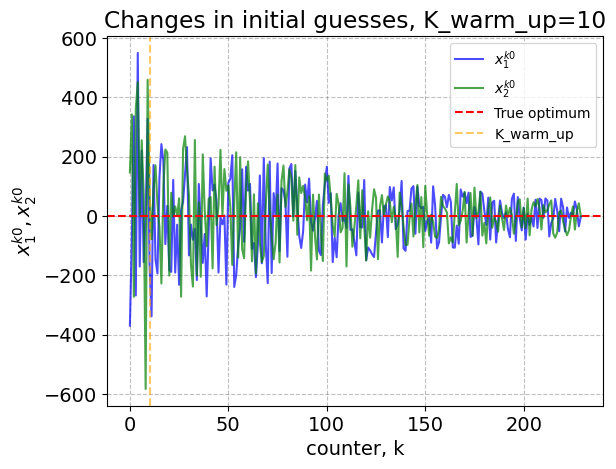

In [21]:
# 4. unpack initial guesses
x_k0_1s = [i[0] for i in x_k0s ]
x_k0_2s = [i[1] for i in x_k0s ]
k = np.arange(len(x_k0_1s))

# 5. plot results 
# a. main 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# b. plot values 
# i. for x_k0-values 
ax.plot(k, x_k0_1s, 'b-', alpha=0.7, label='$x^{k0}_1$')
ax.plot(k, x_k0_2s, 'g-', alpha=0.7, label='$x^{k0}_2$')

# ii. lines on axis
plt.axhline(y=0, color='r', linestyle='--', label='True optimum')
plt.axvline(x=K_warm_up, color='orange', alpha=0.6, linestyle='--', label='K_warm_up')

# c. title and labels  
ax.set_title(f"Changes in initial guesses, K_warm_up={K_warm_up}" )
ax.set_xlabel('counter, k')
ax.set_ylabel('$x^{k0}_1, x^{k0}_2$')

# d. legend
ax.legend(loc='upper right', fontsize=10);

As we can see from the figure, there seems to be a higher variation in the initial guesses, when we are in 'the warm-up'-period, $[0, \underline{K} ]$. <br>
Afterwards the initial guesses slowly converges toward the true optimum, which suggests that the revized initial guess from 3D, increases the speed of convergence. <br>


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [17]:
# we rerun previous code, with the new change in K_warm_up!

# 2. specify settings 
lower_bound = -600
upper_bound = 600
tol = 1e-8
K_warm_up = 100 # changed!
K_max = 1000

# 3. run optimizer on griewank & check results 
np.random.seed(1234) # for reproducibility 
x_star,x_k0s  = glob_opt_multi_start(griewank, lower_bound, upper_bound, tol, K_warm_up, K_max)

print(f'x_star = {x_star}')
print(f'x_star == [0,0] = {np.isclose(x_star,[0,0])}')
print(f'k={len(x_k0s)}-simulations')

break
x_star = [-7.91600055e-09  9.46688217e-10]
x_star == [0,0] = [ True  True]
k=334-simulations


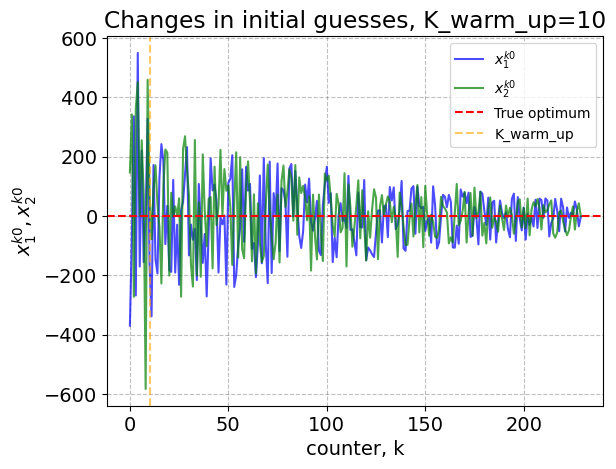

In [22]:
# 4. unpack initial guesses
x_k0_1s = [i[0] for i in x_k0s ]
x_k0_2s = [i[1] for i in x_k0s ]
k = np.arange(len(x_k0_1s))

# 5. plot results 
# a. main 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# b. plot values 
# i. for x_k0-values 
ax.plot(k, x_k0_1s, 'b-', alpha=0.7, label='$x^{k0}_1$')
ax.plot(k, x_k0_2s, 'g-', alpha=0.7, label='$x^{k0}_2$')

# ii. lines on axis
ax.axhline(y=0, color='r', linestyle='--', label='True optimum')
ax.axvline(x=K_warm_up, color='orange', alpha=0.6, linestyle='--', label='K_warm_up')

# c. title and labels  
ax.set_title(f"Changes in initial guesses, K_warm_up={K_warm_up}" )
ax.set_xlabel('counter, k')
ax.set_ylabel('$x^{k0}_1, x^{k0}_2$')

# d. legend
ax.legend(loc='upper right', fontsize=10);

By prolonging the warm-up period, we do overall increase the number of iterations performed to get the true values. From 230 previously to 334. <br>
In this figure we see the same tendency in variation from the previous figure, i.e. a higher variance in the 'warm-up' period, and aterward slowly decreasing. <br>
This adds weight to our suggestion, that the revized initial guess from 3D, does in fact increase the speed of the convergens to the true value. <br>
**Therefore we conclude that it is a bad idea to increase $ \underline{K} $ to $100$**.

# CODE GRAVEYARD

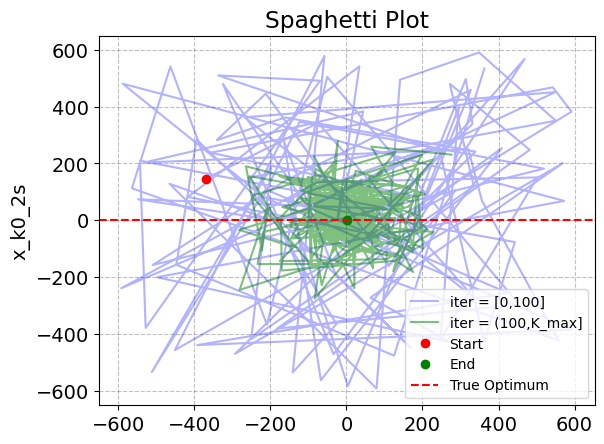

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(x_k0_1s[:100], x_k0_2s[:100], 'b-', alpha=0.3, label='iter = [0,100]')  # First 100 observations with blue color
ax.plot(x_k0_1s[100:], x_k0_2s[100:], 'g-', alpha=0.5, label='iter = (100,K_max]')  # Observations after 100 with green color

# Mark the start and end points
ax.plot(x_k0_1s[0], x_k0_2s[0], 'ro', label='Start')
ax.plot(x_k0_1s[-1], x_k0_2s[-1], 'go', label='End')

# Add the true optimum line
plt.axhline(y=0, color='r', linestyle='--', label='True Optimum')
plt.axhline(y=0, color='r', linestyle='--'

# Set the ylabel, title, legend, and grid
plt.ylabel('x_k0_2s')
plt.title('Spaghetti Plot')
plt.legend(fontsize = 10)
plt.grid(True)

# Show the plot
plt.show()